# Maximum Intensity Projection Optimization

Compare denoising and enhancement methods for cleaner max projections suitable for segmentation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, restoration, morphology, exposure
from skimage.filters import median, gaussian
from skimage.morphology import disk, ball
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
import cv2

from mbo_utilities import imread

ImportError: cannot import name 'index_length' from 'mbo_utilities.util' (C:\Users\RBO\repos\mbo_utilities\mbo_utilities\util.py)

In [ ]:
# load data - expects TYX array (single z-plane)
data = imread(r"D:\cj\2025-11-21\raw\vdaq0")
array = data[:, 0, :, :]
print(f"shape: {data.shape}, dtype: {array.dtype}")

Counting frames:   0%|          | 0/1 [00:00<?, ?it/s]

shape: (970, 2, 772, 735), dtype: int16


In [3]:
# normalize to float32 [0,1] for processing
def normalize(x):
    x = x.astype(np.float32)
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

data_norm = normalize(array)

## Projection Methods

In [4]:
def max_proj(x):
    """standard max projection"""
    return x.max(axis=0)

def mean_proj(x):
    """mean projection - less noisy but lower contrast"""
    return x.mean(axis=0)

def percentile_proj(x, p=99):
    """percentile projection - robust to outliers"""
    return np.percentile(x, p, axis=0)

def std_proj(x):
    """std projection - highlights dynamic pixels"""
    return x.std(axis=0)

## Pre-projection Denoising (applied to each frame)

In [5]:
def temporal_median(x, size=5):
    """median filter along time axis - removes salt/pepper noise"""
    return ndimage.median_filter(x, size=(size, 1, 1))

def spatial_gaussian(x, sigma=1):
    """gaussian blur each frame - smooths noise"""
    return ndimage.gaussian_filter(x, sigma=(0, sigma, sigma))

def spatial_median(x, size=3):
    """spatial median filter - edge-preserving denoising"""
    return ndimage.median_filter(x, size=(1, size, size))

## Post-projection Enhancement

In [6]:
def enhance_clahe(img, clip_limit=0.03):
    """contrast limited adaptive histogram equalization"""
    return exposure.equalize_adapthist(normalize(img), clip_limit=clip_limit)

def enhance_gamma(img, gamma=0.7):
    """gamma correction - <1 brightens darks, >1 darkens"""
    return exposure.adjust_gamma(normalize(img), gamma=gamma)

def enhance_sigmoid(img, cutoff=0.5, gain=10):
    """sigmoid contrast - increases separation of low/high values"""
    return exposure.adjust_sigmoid(normalize(img), cutoff=cutoff, gain=gain)

def bilateral_filter(img, sigma_spatial=3, sigma_color=0.1):
    """bilateral - smooths while preserving edges"""
    return denoise_bilateral(normalize(img), sigma_spatial=sigma_spatial, sigma_color=sigma_color)

def tv_denoise(img, weight=0.1):
    """total variation denoising - removes noise, preserves edges"""
    return denoise_tv_chambolle(normalize(img), weight=weight)

def tophat_enhance(img, radius=15):
    """white tophat - extracts bright features on dark background"""
    selem = disk(radius)
    return morphology.white_tophat(normalize(img), selem)

## Generate All Projections

In [7]:
results = {}

# baseline projections
results['max'] = max_proj(data_norm)
results['mean'] = mean_proj(data_norm)
results['p99'] = percentile_proj(data_norm, 99)
results['p95'] = percentile_proj(data_norm, 95)
results['std'] = std_proj(data_norm)

# pre-filtered then max
results['temporal_med + max'] = max_proj(temporal_median(data_norm, 5))
results['spatial_gauss + max'] = max_proj(spatial_gaussian(data_norm, 1))
results['spatial_med + max'] = max_proj(spatial_median(data_norm, 3))

# post-enhanced max
base_max = results['max']
results['max + clahe'] = enhance_clahe(base_max)
results['max + gamma0.7'] = enhance_gamma(base_max, 0.7)
results['max + sigmoid'] = enhance_sigmoid(base_max, 0.3, 8)
results['max + bilateral'] = bilateral_filter(base_max)
results['max + tv'] = tv_denoise(base_max, 0.05)
results['max + tophat'] = tophat_enhance(base_max, 10)

# combined: pre-filter + project + post-enhance
filtered = spatial_gaussian(data_norm, 1)
proj = max_proj(filtered)
results['gauss + max + clahe'] = enhance_clahe(proj)
results['gauss + max + bilateral'] = bilateral_filter(proj)

# temporal + spatial pre-filter
filtered2 = spatial_median(temporal_median(data_norm, 3), 3)
results['temp+spat_med + max'] = max_proj(filtered2)

print(f"generated {len(results)} projections")

generated 17 projections


In [10]:
for name, proj in results.items():
    print(f"{name} - {proj.shape}")

max - (772, 735)
mean - (772, 735)
p99 - (772, 735)
p95 - (772, 735)
std - (772, 735)
temporal_med + max - (772, 735)
spatial_gauss + max - (772, 735)
spatial_med + max - (772, 735)
max + clahe - (772, 735)
max + gamma0.7 - (772, 735)
max + sigmoid - (772, 735)
max + bilateral - (772, 735)
max + tv - (772, 735)
max + tophat - (772, 735)
gauss + max + clahe - (772, 735)
gauss + max + bilateral - (772, 735)
temp+spat_med + max - (772, 735)


## Display All on Same Colorscale

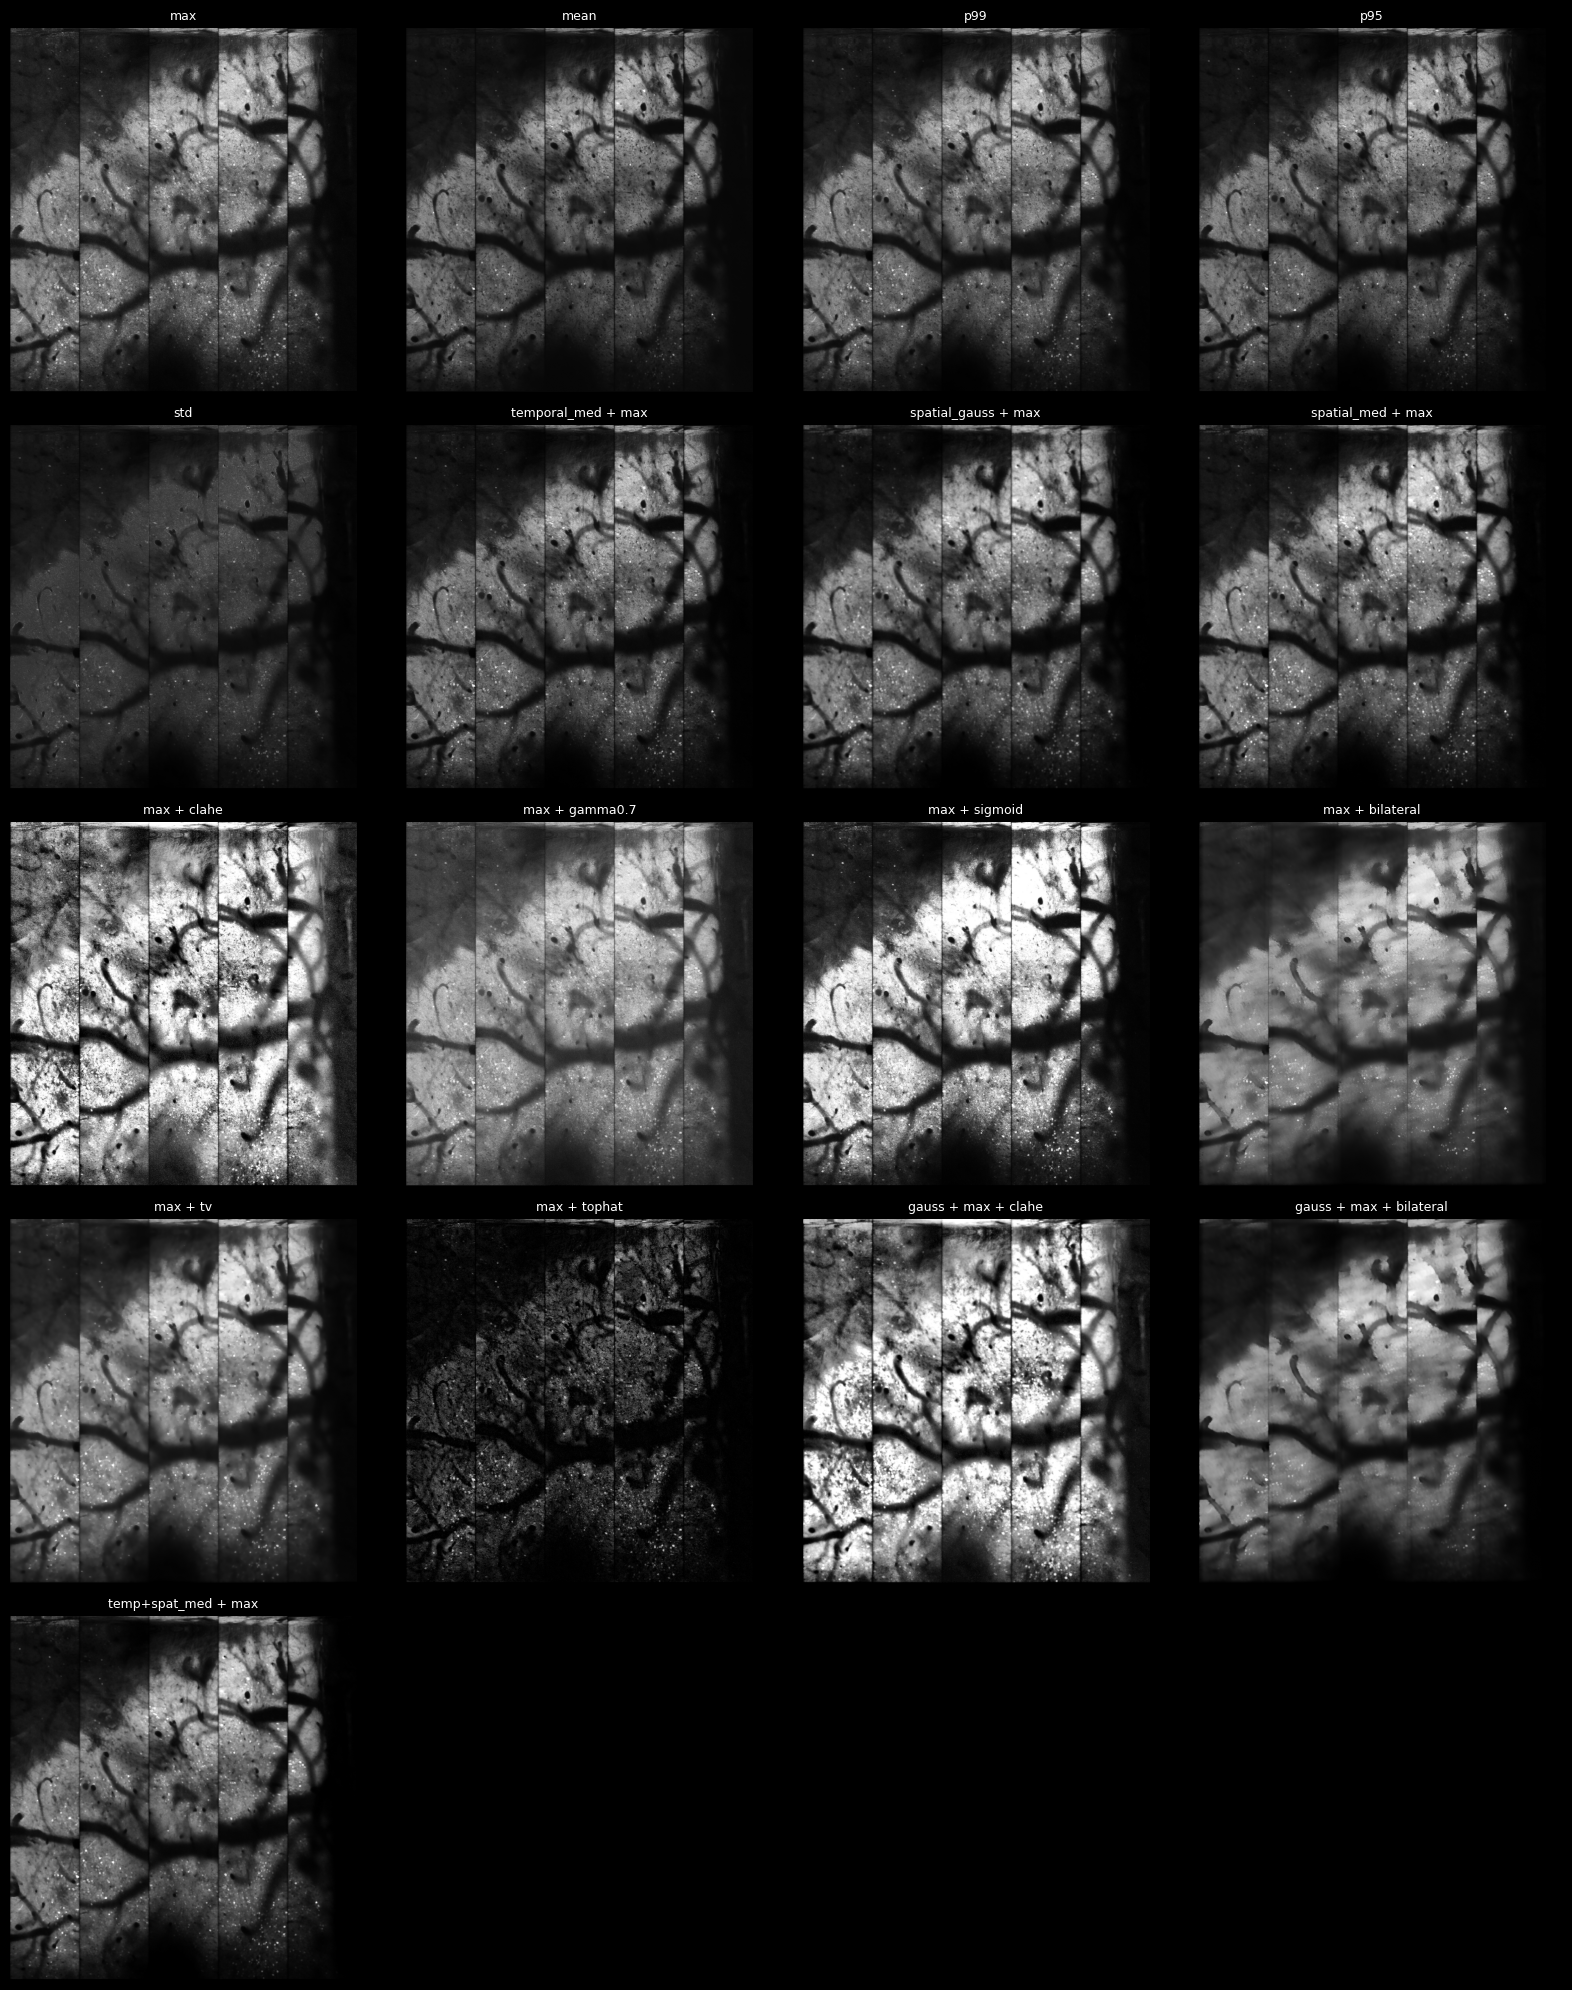

In [16]:
# same colorscale?
all_vals = np.concatenate([normalize(v).ravel() for v in results.values()])
vmin, vmax = np.percentile(all_vals, [1, 99])

n = len(results)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.ravel()

for ax, (name, img) in zip(axes, results.items()):
    im = ax.imshow(normalize(img), cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(name, fontsize=9)
    ax.axis('off')

for ax in axes[n:]:
    ax.axis('off')

# fig.colorbar(im, ax=axes, shrink=0.6, label='normalized intensity')
plt.tight_layout()
plt.show()

## zoom

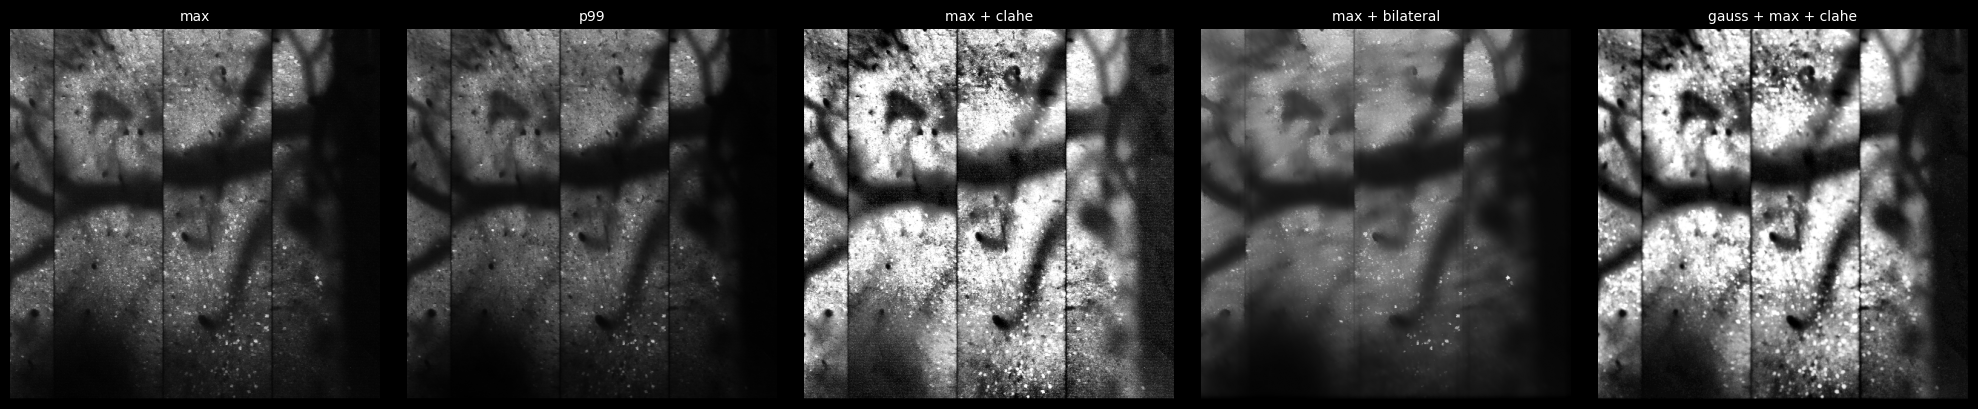

In [ ]:
# select region of interest
y0, y1 = -500, -1
x0, x1 = -500, -1

top_methods = ['max', 'p99', 'max + clahe', 'max + bilateral', 'gauss + max + clahe']

fig, axes = plt.subplots(1, len(top_methods), figsize=(4*len(top_methods), 4))

for ax, name in zip(axes, top_methods):
    img = normalize(results[name])[y0:y1, x0:x1]
    ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(name, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## bg subtraction + enhancement

In [11]:
def super_projection(data, bg_radius=50, enhance=True):
    """
    1. temporal median
    2. max projection
    3. rolling ball background subtraction
    4. CLAHE enhancement
    """
    filtered = temporal_median(data, 3)

    # project
    proj = max_proj(filtered)

    # background subtraction via morphological opening
    background = ndimage.grey_opening(proj, size=bg_radius)
    subtracted = proj - background
    subtracted = np.clip(subtracted, 0, None)

    if enhance:
         return enhance_clahe(subtracted, clip_limit=0.02)
    return subtracted

seg_proj = super_projection(data_norm)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(results['max'], cmap='gray')
axes[0].set_title('raw max projection')
axes[1].imshow(seg_proj, cmap='gray')
axes[1].set_title('projection')
axes[2].imshow(seg_proj, cmap='gray')
axes[2].set_title('highest-cell count')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'data_norm' is not defined

## Summary

**Best for general visualization:**
- `p99` or `p95` - robust to hot pixels
- `max + clahe` - enhanced contrast

**Best for segmentation:**
- `segment_ready_projection()` - background subtracted + enhanced
- `max + bilateral` - edge-preserving smoothing

**Best for noisy data:**
- `temp+spat_med + max` - aggressive denoising before projection
- `gauss + max + bilateral` - smooth + edge-preserve

## Cellpose Segmentation Comparison

In [20]:
from cellpose import models, core

model = models.CellposeModel(gpu=core.use_gpu())
print(f"GPU available: {core.use_gpu()}")

DIAMETER = 4
CELLPROB_THRESHOLD = -6.0
FLOW_THRESHOLD = 0.0

def normalize99(img):
    """normalize to 1-99 percentile range"""
    p1, p99 = np.percentile(img, [1, 99])
    return np.clip((img - p1) / (p99 - p1 + 1e-8), 0, 1)

def mask_overlay(img, masks, alpha=0.4):
    """overlay colored masks on grayscale image"""
    from matplotlib.colors import hsv_to_rgb
    img_norm = normalize99(img)
    rgb = np.stack([img_norm]*3, axis=-1)
    if masks.max() > 0:
        n = masks.max()
        np.random.seed(42)
        colors = np.zeros((n+1, 3))
        for i in range(1, n+1):
            colors[i] = hsv_to_rgb([np.random.rand(), 0.8, 0.9])
        mask_rgb = colors[masks]
        mask_area = masks > 0
        rgb[mask_area] = (1-alpha)*rgb[mask_area] + alpha*mask_rgb[mask_area]
    return np.clip(rgb, 0, 1)

GPU available: True


In [21]:
# run cellpose on selected projection methods
test_methods = [
    'max', 'p99',
    'max + clahe',
    'max + bilateral',
    'gauss + max + clahe',
    'temp+spat_med + max'
]

# add super_projection result
results['super'] = seg_proj

test_methods.append('super')

cellpose_results = {}

for name in test_methods:
    proj = results[name]
    img = normalize99(proj)
    masks, _, _ = model.eval(
        img,
        diameter=DIAMETER,
        cellprob_threshold=CELLPROB_THRESHOLD,
        flow_threshold=FLOW_THRESHOLD,
    )
    n_cells = masks.max()
    cellpose_results[name] = {'masks': masks, 'n_cells': n_cells, 'proj': proj}
    print(f"{name}: {n_cells} cells")

print(f"\nCell count summary:")
for name, r in sorted(cellpose_results.items(), key=lambda x: -x[1]['n_cells']):
    print(f"  {r['n_cells']:4d} cells - {name}")

Resizing is deprecated in v4.0.1+


max: 604 cells


Resizing is deprecated in v4.0.1+


p99: 695 cells


Resizing is deprecated in v4.0.1+


max + clahe: 521 cells


Resizing is deprecated in v4.0.1+


max + bilateral: 326 cells


Resizing is deprecated in v4.0.1+


gauss + max + clahe: 719 cells


Resizing is deprecated in v4.0.1+


temp+spat_med + max: 732 cells


Resizing is deprecated in v4.0.1+


super: 629 cells

Cell count summary:
   732 cells - temp+spat_med + max
   719 cells - gauss + max + clahe
   695 cells - p99
   629 cells - super
   604 cells - max
   521 cells - max + clahe
   326 cells - max + bilateral


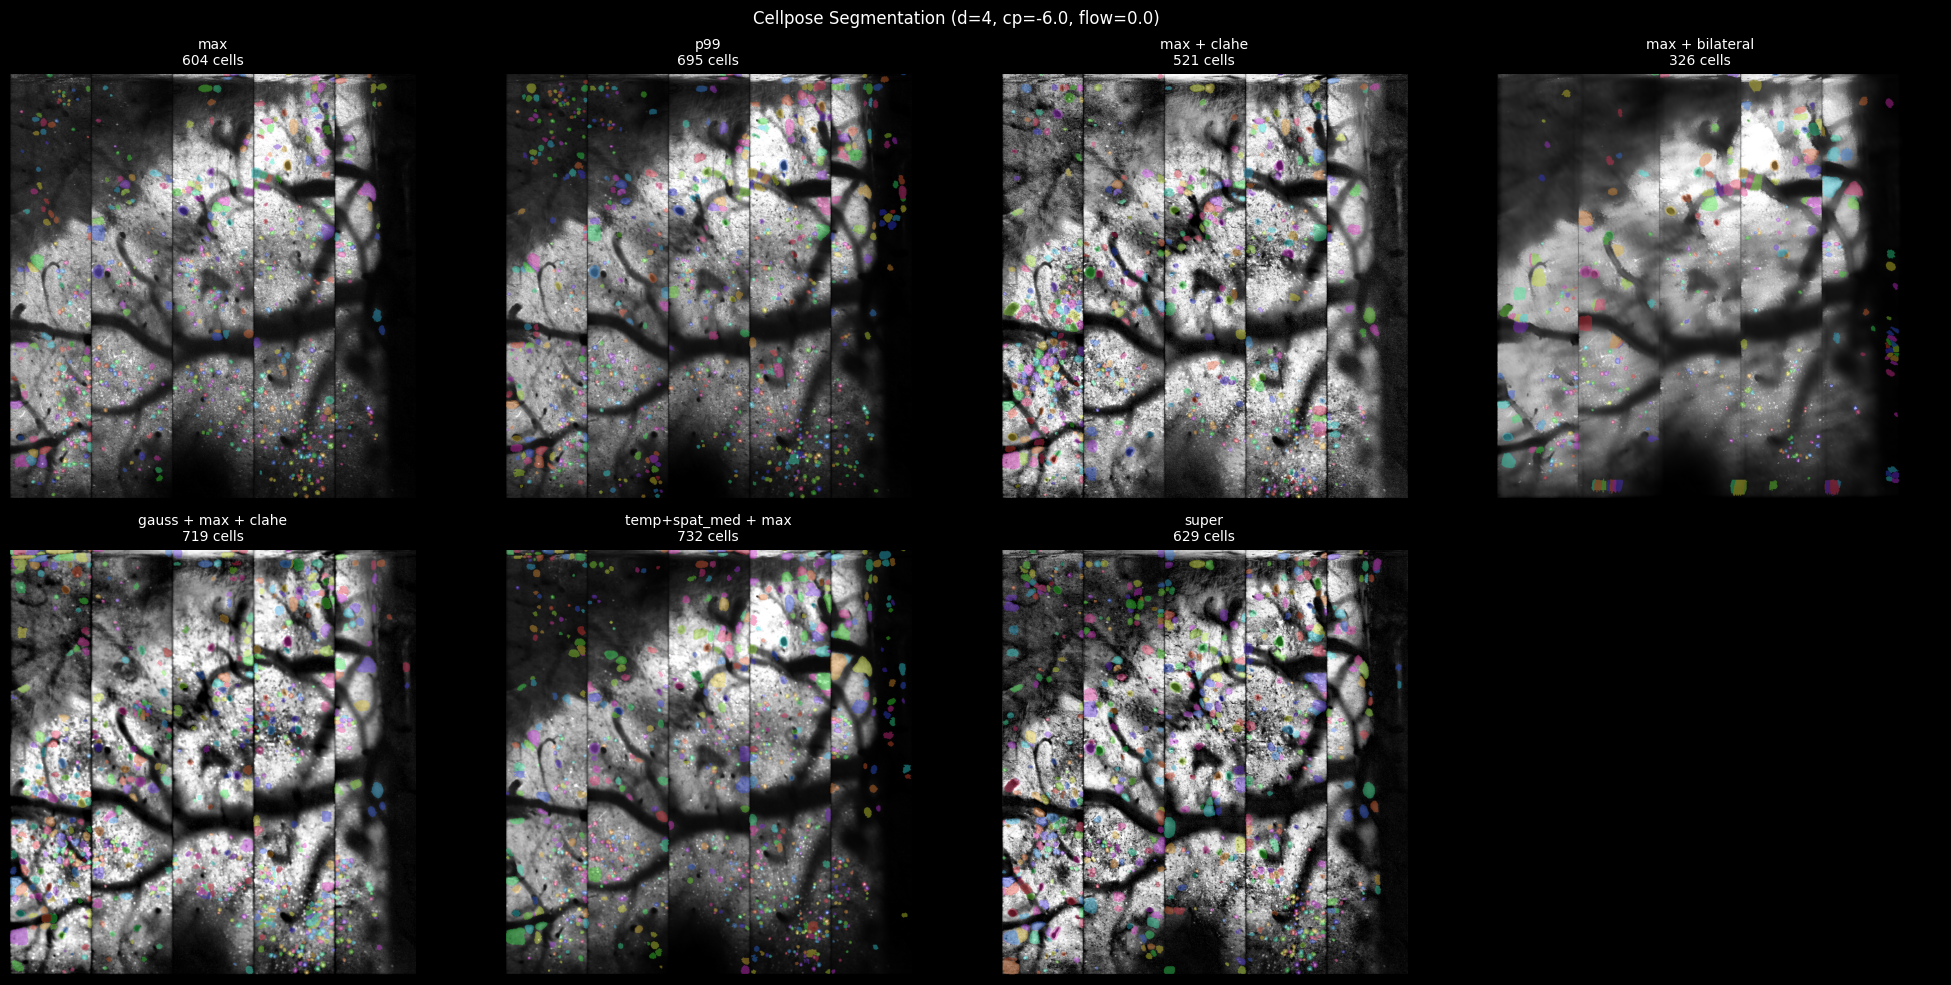

In [22]:
# full image with mask overlays
n = len(cellpose_results)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.ravel()

for ax, (name, r) in zip(axes, cellpose_results.items()):
    overlay = mask_overlay(r['proj'], r['masks'])
    ax.imshow(overlay)
    ax.set_title(f"{name}\n{r['n_cells']} cells", fontsize=10)
    ax.axis('off')

for ax in axes[n:]:
    ax.axis('off')

plt.suptitle(f"Cellpose Segmentation (d={DIAMETER}, cp={CELLPROB_THRESHOLD}, flow={FLOW_THRESHOLD})", fontsize=12)
plt.tight_layout()
plt.show()

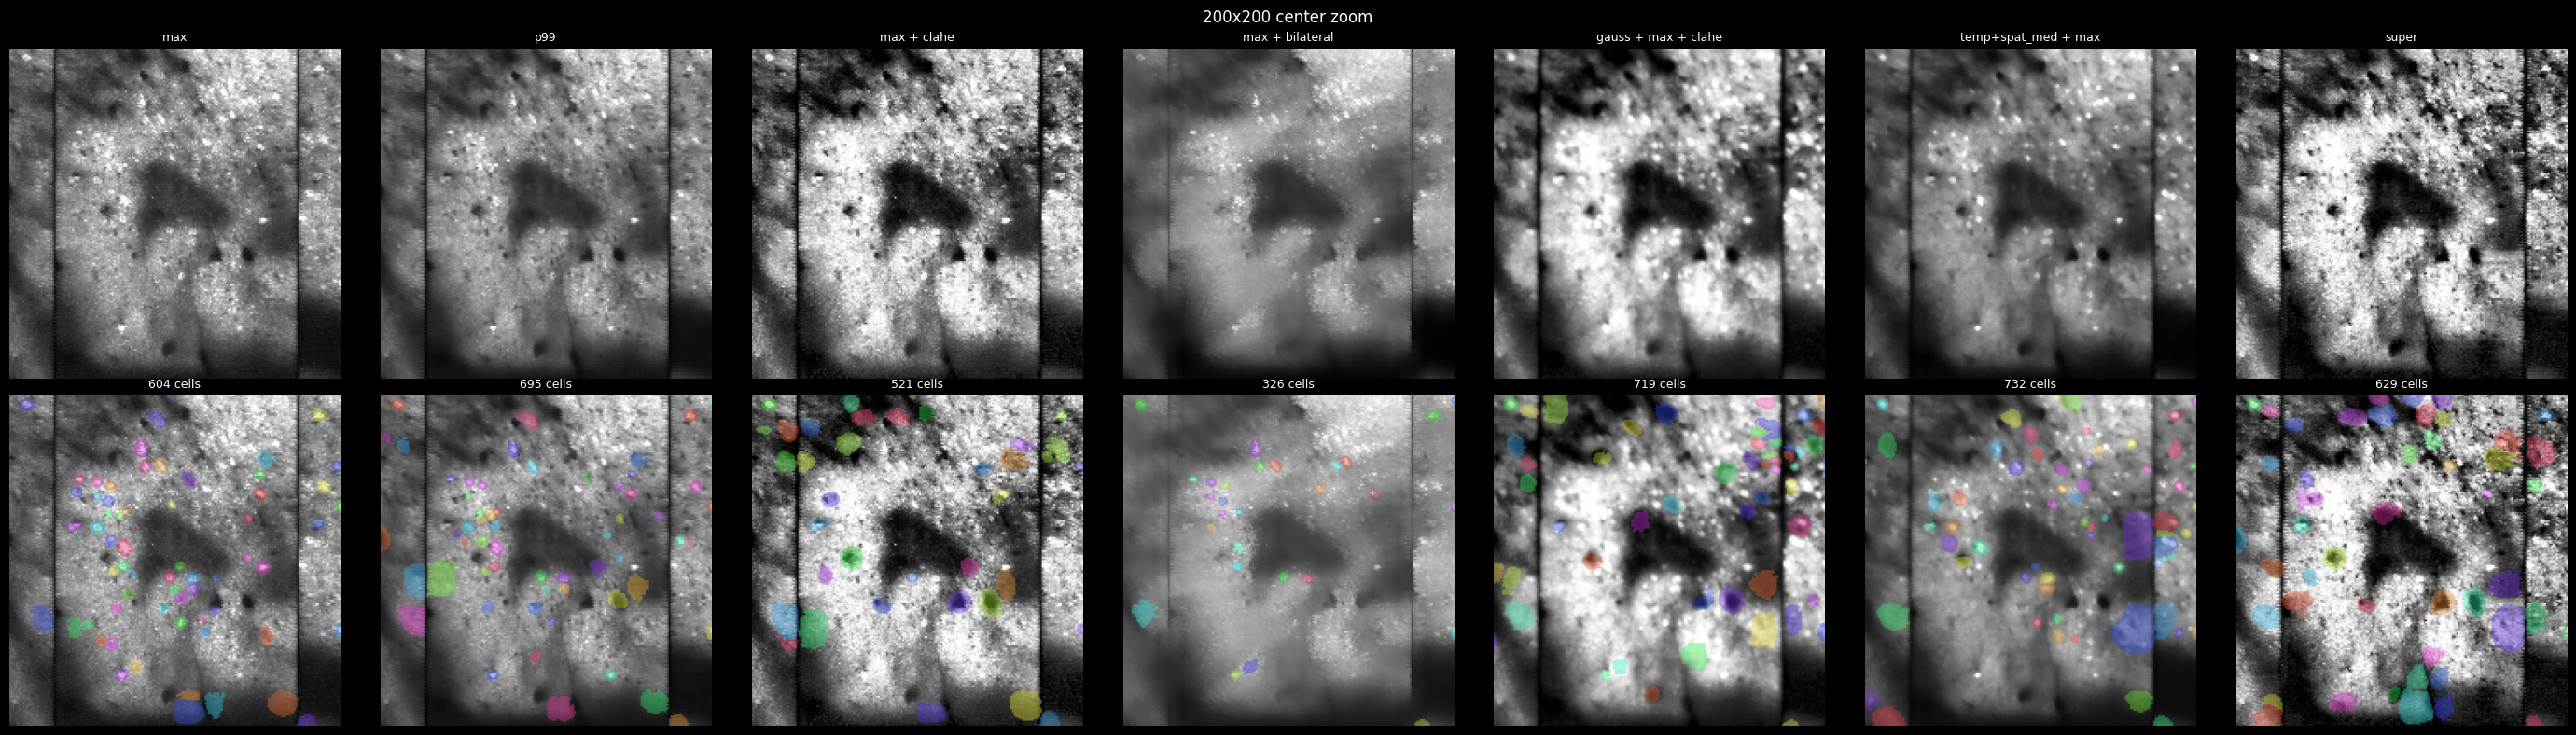

In [23]:
# 200x200 center zoom with masks
h, w = list(cellpose_results.values())[0]['masks'].shape
cy, cx = h // 2, w // 2
sz = 100  # half-size

fig, axes = plt.subplots(2, len(cellpose_results), figsize=(4*len(cellpose_results), 8))

for i, (name, r) in enumerate(cellpose_results.items()):
    # raw projection zoom
    proj_crop = normalize99(r['proj'])[cy-sz:cy+sz, cx-sz:cx+sz]
    axes[0, i].imshow(proj_crop, cmap='gray')
    axes[0, i].set_title(name, fontsize=9)
    axes[0, i].axis('off')

    # overlay zoom
    overlay = mask_overlay(r['proj'], r['masks'])
    overlay_crop = overlay[cy-sz:cy+sz, cx-sz:cx+sz]
    axes[1, i].imshow(overlay_crop)
    axes[1, i].set_title(f"{r['n_cells']} cells", fontsize=9)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('projection', fontsize=10)
axes[1, 0].set_ylabel('masks', fontsize=10)
plt.suptitle("200x200 center zoom", fontsize=12)
plt.tight_layout()
plt.show()

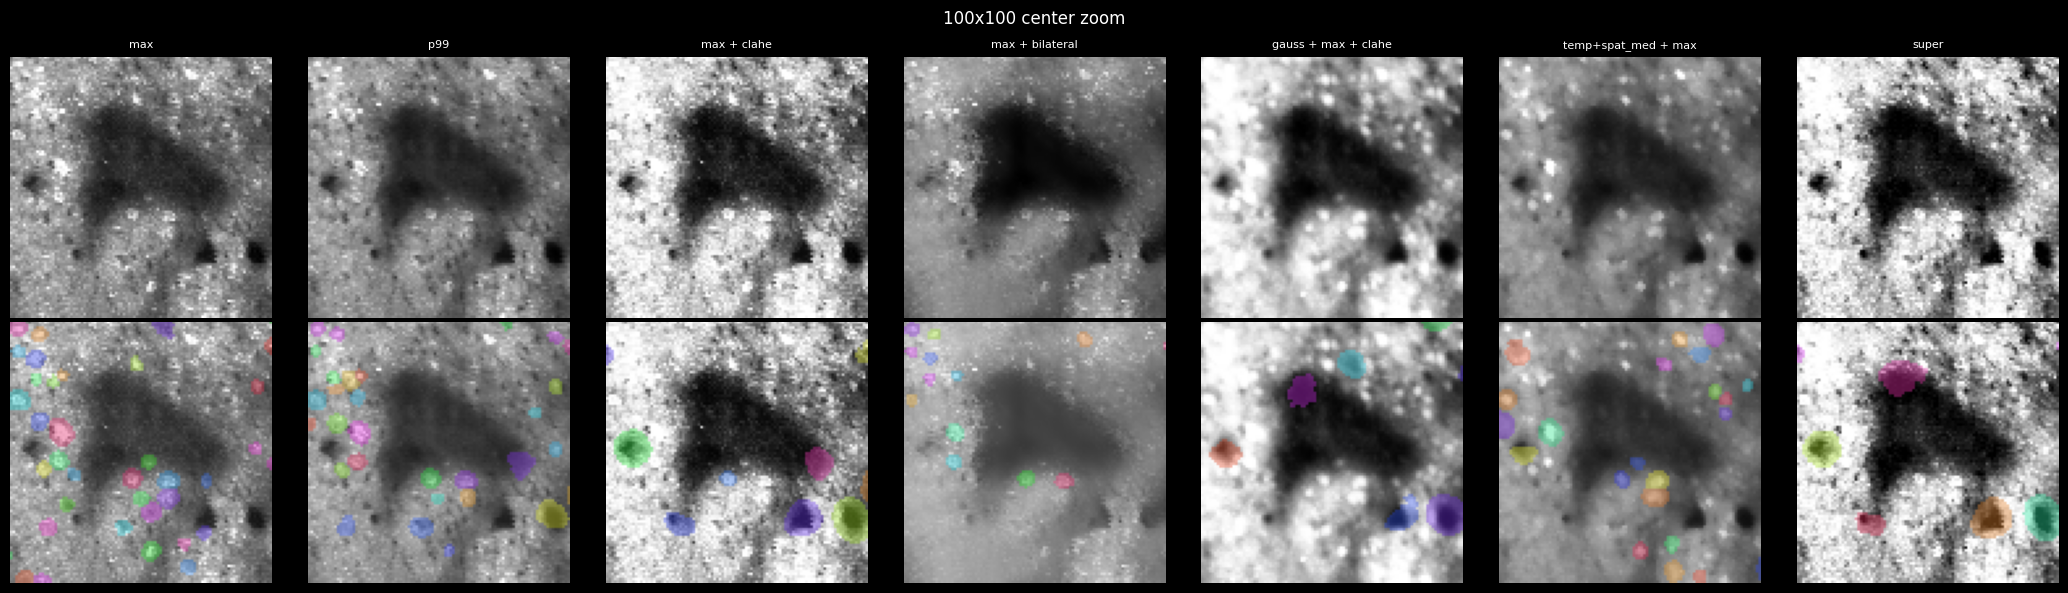

In [24]:
# 100x100 zoom - tighter view
sz = 50  # half-size for 100x100

fig, axes = plt.subplots(2, len(cellpose_results), figsize=(3*len(cellpose_results), 6))

for i, (name, r) in enumerate(cellpose_results.items()):
    # raw projection zoom
    proj_crop = normalize99(r['proj'])[cy-sz:cy+sz, cx-sz:cx+sz]
    axes[0, i].imshow(proj_crop, cmap='gray')
    axes[0, i].set_title(name, fontsize=8)
    axes[0, i].axis('off')

    # overlay zoom
    overlay = mask_overlay(r['proj'], r['masks'])
    overlay_crop = overlay[cy-sz:cy+sz, cx-sz:cx+sz]
    axes[1, i].imshow(overlay_crop)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('projection', fontsize=10)
axes[1, 0].set_ylabel('masks', fontsize=10)
plt.suptitle("100x100 center zoom", fontsize=12)
plt.tight_layout()
plt.show()

## Save/Load Results

Use `mbo_utilities.analysis` functions for GUI-compatible save/load.

In [3]:
from mbo_utilities.analysis import (
    save_cellpose_results,
    load_cellpose_results,
    open_cellpose_gui,
    save_cellpose_comparison,
)

In [ ]:
# save all comparison results
save_cellpose_comparison(
    r"D:\cj\2025-11-21\cellpose_comparison",
    cellpose_results,
    base_name="max_proj"
)

In [4]:
help(save_cellpose_results)

Help on function save_results in module mbo_utilities.analysis.cellpose:

save_results(save_path: Union[str, pathlib.Path], masks: numpy.ndarray, image: numpy.ndarray, flows: tuple = None, styles: numpy.ndarray = None, diameter: float = None, cellprob_threshold: float = 0.0, flow_threshold: float = 0.4, name: str = None) -> pathlib.Path
    save cellpose results in gui-compatible format.

    creates:
    - {name}_seg.npy: cellpose gui format (can be loaded directly)
    - {name}_masks.tif: label image viewable in imagej/napari
    - {name}_stat.npy: suite2p-compatible roi statistics

    parameters
    ----------
    save_path : str or Path
        directory to save results.
    masks : ndarray
        labeled mask array from cellpose (0=background, 1,2,...=roi ids).
    image : ndarray
        image used for segmentation (projection).
    flows : tuple, optional
        flow outputs from cellpose model.eval().
    styles : ndarray, optional
        style vector from cellpose.
    dia

In [26]:
# save single result (e.g., best method)
best_method = max(cellpose_results.items(), key=lambda x: x[1]['n_cells'])[0]
best = cellpose_results[best_method]

seg_file = save_cellpose_results(
    r"D:\cj\2025-11-21\cellpose_comparison",
    masks=best['masks'],
    image=best['proj'],
    diameter=DIAMETER,
    cellprob_threshold=CELLPROB_THRESHOLD,
    flow_threshold=FLOW_THRESHOLD,
    name=f"best_{best_method.replace(' ', '_')}",
)
print(f"best method: {best_method} with {best['n_cells']} cells")

saved 732 rois to D:\cj\2025-11-21\cellpose_comparison
best method: temp+spat_med + max with 732 cells


In [6]:
help(load_cellpose_results)

Help on function load_results in module mbo_utilities.analysis.cellpose:

load_results(seg_path: Union[str, pathlib.Path]) -> dict
    load cellpose results from _seg.npy file.

    parameters
    ----------
    seg_path : str or Path
        path to _seg.npy file or directory containing it.

    returns
    -------
    dict
        dictionary with 'masks', 'img', 'flows', 'outlines', etc.



In [4]:
# load results back
seg_file = load_cellpose_results(r"D:\cj\2025-11-21\cellpose_comparison")
print(f"loaded keys: {list(seg_file.keys())}")
print(f"masks shape: {seg_file['masks'].shape}")
print(f"n_rois: {seg_file['masks'].max()}")

loaded keys: ['img', 'masks', 'outlines', 'chan_choose', 'ismanual', 'filename', 'flows', 'est_diam', 'cellprob_threshold', 'flow_threshold']
masks shape: (772, 735)
n_rois: 732


In [5]:
# open in cellpose gui (uncomment to run)
# open_cellpose_gui(seg_file)
help(open_cellpose_gui)

Help on function open_in_gui in module mbo_utilities.analysis.cellpose:

open_in_gui(seg_path: Union[str, pathlib.Path] = None, image: numpy.ndarray = None, masks: numpy.ndarray = None)
    open cellpose gui with results or image.

    parameters
    ----------
    seg_path : str or Path, optional
        path to _seg.npy file to load in gui.
    image : ndarray, optional
        image to open directly (without loading from file).
    masks : ndarray, optional
        masks to overlay (requires image).

    notes
    -----
    requires cellpose to be installed with gui dependencies.



In [ ]:
from qtpy.QtWidgets import QCheckBox
if not hasattr(QCheckBox, 'checkStateChanged'):
    QCheckBox.checkStateChanged = QCheckBox.stateChanged
open_cellpose_gui(r"D:\cj\2025-11-21\cellpose_comparison")

2025-12-11 12:46:44,183 [INFO] WRITING LOG OUTPUT TO C:\Users\RBO\.cellpose\run.log
2025-12-11 12:46:44,183 [INFO] 
cellpose version: 	4.0.8 
platform:       	win32 
python version: 	3.12.9 
torch version:  	2.9.1+cu126
2025-12-11 12:46:44,526 [INFO] ** TORCH CUDA version installed and working. **
2025-12-11 12:46:44,940 [INFO] processing grayscale image with (772, 735) HW
GUI_INFO: image shape: (772, 735, 3)
GUI_INFO: normalization checked: computing saturation levels (and optionally filtered image)
{'lowhigh': None, 'percentile': [1.0, 99.0], 'normalize': True, 'norm3D': True, 'sharpen_radius': 0.0, 'smooth_radius': 0.0, 'tile_norm_blocksize': 0.0, 'tile_norm_smooth3D': 0.0, 'invert': False}
[0, 255.0]
(1, 772, 735, 3)
GUI_INFO: 732 masks found
GUI_INFO: creating cellcolors and drawing masks


SystemExit: 0

: 